# 1 Setting up Spark NLP

In [1]:
# Mount google drive
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
# Install Java
#!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Download Spark
#if os.path.isfile("./spark-3.5.1-bin-hadoop3.tgz") == False:
#    !wget -q https://downloads.apache.org/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz

# Unzip the file
#!tar xf spark-3.5.1-bin-hadoop3.tgz

# Setup environment for Spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = '/home/ubuntu/spark-3.5.1-bin-hadoop3'

# Import findspark and load it
#!pip install -q findspark
import findspark
findspark.init()

# import spacy for NLP and re for regular expressions
import spacy
spacy.cli.download("en_core_web_sm")
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS
import re

# Install spark-nlp
#!pip install spark-nlp
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.common import *
from pyspark.sql.functions import *
from pyspark.sql.functions import lit
from pyspark.sql.window import Window
from pyspark.sql.types import *
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler, Imputer, OneHotEncoder, StringIndexer
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel, TrainValidationSplit, TrainValidationSplitModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors, VectorUDT
import pyspark.pandas as ps

# Create Spark session
#from pyspark.sql import SparkSession
#spark = SparkSession.builder\
#        .master("local")\
#        .appName("Spark NLP")\
#        .config('spark.executor.memory', "24g")\
#        .getOrCreate()

# Create Spark session with GPU and large memory 24G
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Spark NLP")\
    .master("local[*]")\
    .config("spark.driver.memory","24G")\
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp-gpu_2.12:5.3.1")\
    .getOrCreate()

# Start Spark Session with Spark NLP
#spark = sparknlp.start(gpu=True)
#spark = sparknlp.start(gpu=False)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


/home/ubuntu/spark-3.5.1-bin-hadoop3/python/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(
Ivy Default Cache set to: /home/ubuntu/.ivy2/cache

In [3]:
spark

# 2 Import libraries

In [4]:
import time
import json
import pickle
import urllib.request
# import altair as alt
import pandas as pd
import collections

In [5]:
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image, display, HTML
import pydot
from pydotplus import graph_from_dot_data
from wordcloud import WordCloud

In [6]:
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import ElementTree
import datetime

In [7]:
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, zero_one_loss, classification_report, fbeta_score
from sklearn.utils import resample

In [8]:
import tensorflow as tf
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification, TFBertModel
from datasets import Dataset, DatasetDict
from datasets import ClassLabel, Value, Features
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:
import torch
print("Pytorch CUDA Available =", torch.cuda.is_available())
print("Pytorch CUDA Device Count =", torch.cuda.device_count())
print("Pytorch CUDA Current Device =", torch.cuda.current_device())
print("Pytorch CUDA Current Device Name =", torch.cuda.get_device_name(torch.cuda.current_device()))

Pytorch CUDA Available = True
Pytorch CUDA Device Count = 1
Pytorch CUDA Current Device = 0
Pytorch CUDA Current Device Name = NVIDIA A10G


# 3 Load data

### 3.1 Obtain stratified training and test splits

In [10]:
train_merged_data_conversations_path = 's3a://capstone210/data/train_merged_data_conversations/'
test_merged_data_conversations_path = 's3a://capstone210/data/test_merged_data_conversations/'

train_merged_data_conversations_df = spark.read.parquet(train_merged_data_conversations_path)
test_merged_data_conversations_df = spark.read.parquet(test_merged_data_conversations_path)

In [11]:
#train_df_final = df.filter(col('source') != 'PAN12-test')
train_df_final = train_merged_data_conversations_df
test_df_final = test_merged_data_conversations_df

In [12]:
#train_df_final.take(1)

In [13]:
train_df_final.describe()

DataFrame[summary: string, conversation_id: string, source: string, label: string, conversation_start_time: string, n_people_in_conversation: string, type_conversation: string, merged_text: string, merged_text_id: string, n_texts: string]

In [14]:
train_df_final.count()

87997

In [15]:
train_df_final.groupBy('label')\
              .agg(count('*').alias('count'))\
              .show(truncate = False)

+-----+-----+
|label|count|
+-----+-----+
|1    |2584 |
|0    |85413|
+-----+-----+



In [16]:
#train_df_final.filter(col('label').isin([1])).show(truncate = True)

In [17]:
test_df_final.count()

155128

In [18]:
test_df_final.groupBy('label')\
             .agg(count('*').alias('count'))\
             .show(truncate = False)

+-----+------+
|label|count |
+-----+------+
|1    |2895  |
|0    |152233|
+-----+------+



# 4 Prepare Data before  BERT Tokenization


## 4.1 Type Casting and Clean up Labels

In [19]:
train_df_final.dtypes

[('conversation_id', 'string'),
 ('source', 'string'),
 ('label', 'int'),
 ('conversation_start_time', 'string'),
 ('n_people_in_conversation', 'int'),
 ('type_conversation', 'string'),
 ('merged_text', 'string'),
 ('merged_text_id', 'string'),
 ('n_texts', 'int')]

In [20]:
#train_df_final = train_df_final.withColumn("label", col("label").cast("integer"))

In [21]:
#train_df_final.dtypes

In [22]:
train_df_final = train_df_final.dropna()

In [23]:
train_df_final.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 2584|
|    0|85413|
+-----+-----+



In [24]:
#train_df_final = train_df_final.filter((col('label') == 1) | (col('label') == 0))

In [25]:
#train_df_final.summary().show()

In [26]:
#train_df_final.groupBy('label').count().show()

In [27]:
#train_df_pandas = train_df_final.select('label').toPandas()
#ax = sns.countplot(x="label", data=train_df_pandas)

In [28]:
#plt.pie(train_df_pandas["label"].value_counts(), labels=['normal','groomer'], autopct='%1.1f%%')
#plt.show()

In [29]:
# function to undersample dataset automatically
def undersample(df, outcome_col, seed=1234):
  # Split dataset based on outcome
  split0_df = df.filter(col(outcome_col) == 0)
  split1_df = df.filter(col(outcome_col) == 1)
  # determine which split is major vs minor
  if (split0_df.count() > split1_df.count()):
    major_df = split0_df
    minor_df = split1_df
  else:
    minor_df = split0_df
    major_df = split1_df
  ratio = major_df.count()/minor_df.count()
  print("Ratio of major vs minor before sampling: {}".format(ratio))
  # Start under-sampling with Spark
  sampled_majority_df = major_df.sample(False, 1/ratio, seed)
  combined_df = sampled_majority_df.unionAll(minor_df)
  print(f"Final sample size: {combined_df.count()}")
  return combined_df

Ratio of major vs minor before sampling: 33.05456656346749
Final sample size: 5239


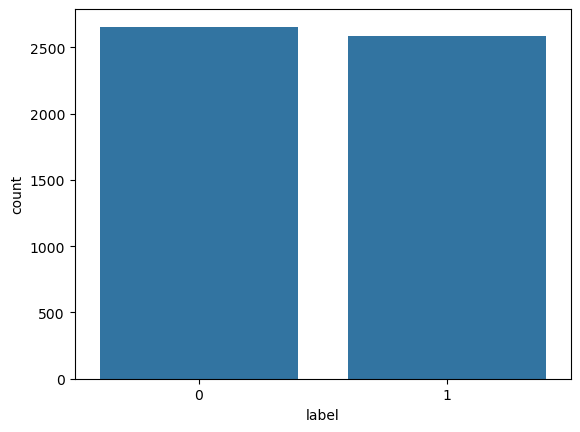

In [30]:
# Perform undersampling technique
df_train_UnderSampled = undersample(train_df_final, outcome_col='label')
df_pandas = df_train_UnderSampled.select('label').toPandas()
ax = sns.countplot(x="label",data=df_pandas)

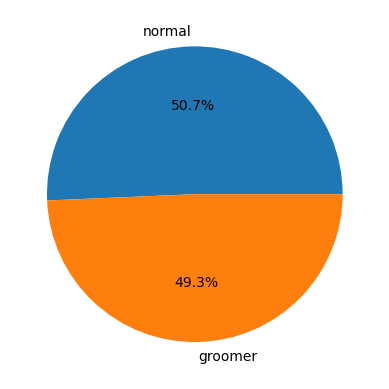

In [31]:
plt.pie(df_pandas["label"].value_counts(), labels=['normal','groomer'], autopct='%1.1f%%')
plt.show()

In [32]:
#df_train_UnderSampled.filter(col('label')==1).select("merged_text").take(5)

### 4.2 Use Spacy English to test tokenization first and remove those samples failed to convert

In [33]:
# Load the SpaCy en_core_web_sm model
nlp = spacy.load('en_core_web_sm', disable=["tagger", "parser", "ner"])

@staticmethod
def get_spacy():

    if "nlp" not in globals():
        globals()["nlp"] = nlp

    return globals()["nlp"]

doc1 = nlp("i love my pet dog")
doc2 = nlp("Maggie is my lovable pet dog!")
print(doc1.vector.size)
print(doc2.vector.size)
print("output:" , doc1.similarity(doc2))

96
96
output: 0.6314009741542267


/opt/conda/envs/pytorch/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
/tmp/ipykernel_61307/749307361.py:16: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  print("output:" , doc1.similarity(doc2))


In [34]:
#vec1 = nlp("i love my pet dog").vector
#vec1

In [35]:
#type(vec1)

#### Build PySpark UDF to convert words into vector

In [36]:
nlpUDF = udf(lambda x: nlp(x).vector.tolist(), ArrayType(FloatType()))

df_train_UnderSampled = df_train_UnderSampled.withColumn('array', nlpUDF(col('merged_text')))

In [37]:
arrayUDF = udf(lambda array: Vectors.dense(array), VectorUDT())

df_train_UnderSampled = df_train_UnderSampled.withColumn('vector', arrayUDF(col('array')))

In [38]:
df_train_UnderSampled = df_train_UnderSampled.withColumn('array_size', size(col('array')))

In [39]:
#df_train_UnderSampled.take(1)

In [40]:
#df_train_UnderSampled.filter(col("array_size") != 96).show()

#### Remove samples which failed to convert into vectors

In [41]:
df_train_UnderSampled = df_train_UnderSampled.filter(col("array_size") == 96)

In [42]:
df_train_UnderSampled.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0| 2655|
|    1| 2583|
+-----+-----+



# 5 Model Building: Tensorflow BERT Pretrained Model

## 5.1 Download Tensorflow BERT Pretrained English language model for transferred-learning/fine-tuning

In [250]:
# Select a BERT Base cased pretrained model
model_checkpoint = "bert-base-cased"
#model_checkpoint = "ydshieh/bert-base-uncased-yelp-polarity"

In [251]:
# use the AutoTokenizer object to avoid simple configuration mistakes 
# because it insures that we get the correct tokenizer given our pre-trained model.
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [252]:
# Testing the tokenizer 
tokenizer("Hello, we only need one sentence for our task but these reviews often have more.")

{'input_ids': [101, 8667, 117, 1195, 1178, 1444, 1141, 5650, 1111, 1412, 4579, 1133, 1292, 3761, 1510, 1138, 1167, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [253]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2) # 2 classes for 0 and 1
#model = TFBertModel.from_pretrained('bert-base-cased')

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### First understand this pretrained model

In [254]:
bert_input = tokenizer(['This is great!', 
                        'This is terrible!'],
              max_length=10,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

bert_input

{'input_ids': <tf.Tensor: shape=(2, 10), dtype=int32, numpy=
array([[ 101, 1188, 1110, 1632,  106,  102,    0,    0,    0,    0],
       [ 101, 1188, 1110, 6434,  106,  102,    0,    0,    0,    0]],
      dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(2, 10), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 10), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0]], dtype=int32)>}

In [255]:
len(model.weights)

201

In [256]:
model.weights[0]

<tf.Variable 'tf_bert_for_sequence_classification_5/bert/embeddings/word_embeddings/weight:0' shape=(28996, 768) dtype=float32, numpy=
array([[-0.00054784, -0.04156886,  0.01308366, ..., -0.0038919 ,
        -0.0335485 ,  0.0149841 ],
       [ 0.01688265, -0.03106827,  0.0042053 , ..., -0.01474032,
        -0.03561099, -0.0036223 ],
       [-0.00057234, -0.02673604,  0.00803954, ..., -0.01002474,
        -0.0331164 , -0.01651673],
       ...,
       [-0.00643814,  0.01658491, -0.02035619, ..., -0.04178825,
        -0.049201  ,  0.00416085],
       [-0.00483562, -0.00267701, -0.02901638, ..., -0.05116647,
         0.00449265, -0.01177113],
       [ 0.03134822, -0.02974372, -0.02302896, ..., -0.01454749,
        -0.05249038,  0.02843569]], dtype=float32)>

In [257]:
model.weights[-1]

<tf.Variable 'tf_bert_for_sequence_classification_5/classifier/bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>

In [258]:
bert_output = model(bert_input)
bert_output

TFSequenceClassifierOutput(loss=None, logits=<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 0.44299513, -0.4776027 ],
       [ 0.4236179 , -0.4523309 ]], dtype=float32)>, hidden_states=None, attentions=None)

In [259]:
bert_output["logits"]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 0.44299513, -0.4776027 ],
       [ 0.4236179 , -0.4523309 ]], dtype=float32)>

## 5.2 Tokenize Inputs and prepare Tensorflow Train and Test Datasets

In [179]:
df_pd_train = df_train_UnderSampled.select('merged_text','label').toPandas()

In [180]:
df_pd_test = test_df_final.select('merged_text','label').toPandas()

In [181]:
# 5% for validation
df_split_train, df_split_val = train_test_split(
    df_pd_train, test_size=0.05, stratify=df_pd_train["label"].values, random_state=42
)

In [182]:
df_split_train.head()

,merged_text,label
2585,. Hello? .,0
1141,hey 16 f us u? o were? maybe wow well a little...,0
2938,ill check back in a lil bit,1
644,hey Mountains Neutral Yes Cold. m or f? Kinda ...,0
4755,hey were back finally you want this cock baby ...,1


In [183]:
df_split_train.count()

merged_text    4976
label          4976
dtype: int64

In [184]:
df_split_val.count()

merged_text    262
label          262
dtype: int64

In [185]:
MAX_SEQUENCE_LENGTH = 200                 # set max_length of the input sequence

In [58]:
# Take care of truncation and maximun length for BERT
def tokenize_function(examples):
    # Keys of the returned dictionary will be added to the dataset as columns
    #return tokenizer(examples["merged_text"], padding="longest", truncation=True)
    return tokenizer(examples["merged_text"], max_length=MAX_SEQUENCE_LENGTH, padding="max_length", truncation=True)

In [59]:
df_train_tokenized =  Dataset.from_pandas(df_split_train).map(tokenize_function)

Map:   0%|          | 0/4976 [00:00<?, ? examples/s]

In [60]:
df_val_tokenized =  Dataset.from_pandas(df_split_val).map(tokenize_function)

Map:   0%|          | 0/262 [00:00<?, ? examples/s]

In [61]:
df_test_tokenized =  Dataset.from_pandas(df_pd_test).map(tokenize_function)

Map:   0%|          | 0/155128 [00:00<?, ? examples/s]

In [62]:
print(df_train_tokenized.features)

{'merged_text': Value(dtype='string', id=None), 'label': Value(dtype='int32', id=None), '__index_level_0__': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}


In [63]:
df_train_tokenized

Dataset({
    features: ['merged_text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4976
})

### Casting Label column to the ClassLabel type

In [64]:
ClassLabels = ClassLabel(num_classes=2, names=[0,1])
df_train_tokenized = df_train_tokenized.cast_column('label', ClassLabels)
print(df_train_tokenized.features)

Casting the dataset:   0%|          | 0/4976 [00:00<?, ? examples/s]

{'merged_text': Value(dtype='string', id=None), 'label': ClassLabel(names=[0, 1], id=None), '__index_level_0__': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}


In [65]:
df_val_tokenized = df_val_tokenized.cast_column('label', ClassLabels)

Casting the dataset:   0%|          | 0/262 [00:00<?, ? examples/s]

In [66]:
df_test_tokenized = df_test_tokenized.cast_column('label', ClassLabels)

Casting the dataset:   0%|          | 0/155128 [00:00<?, ? examples/s]

## 5.3 Run Fine-Tuning Model

In [457]:
batch_size = 32
learning_rate = 0.001
#learning_rate = 0.0005
epochs = 40

In [458]:
train_tf_dataset = model.prepare_tf_dataset(df_train_tokenized, shuffle=True, batch_size=batch_size, tokenizer=tokenizer, drop_remainder=False)

In [459]:
val_tf_dataset = model.prepare_tf_dataset(df_val_tokenized, batch_size=batch_size, tokenizer=tokenizer, drop_remainder=False)

In [460]:
test_tf_dataset = model.prepare_tf_dataset(df_test_tokenized, batch_size=batch_size, tokenizer=tokenizer, drop_remainder=False)

In [461]:
# model.compile(
#     #run_eagerly=True,
#     optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#     loss=tf.keras.losses.BinaryFocalCrossentropy(
#         gamma=2.0, from_logits=True, apply_class_balancing=True, label_smoothing=0.03
#     ),
#     #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#     #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     #metrics=tf.keras.metrics.FBetaScore(
#     #    average=None, beta=3.0, threshold=None, name="fbeta_score", dtype=None
#     #)
#     #metrics=tf.metrics.SparseCategoricalAccuracy(),
#     #metrics=tf.keras.metrics.BinaryAccuracy(),
#     #metrics=['accuracy', 'f1', 'precision', 'recall'],
#     metrics=['accuracy', 
#              tf.keras.metrics.Recall(class_id=1),
#              tf.keras.metrics.Precision(class_id=1),
#              tf.keras.metrics.F1Score(average=None, threshold=None, name="f1_score", dtype=None)
#             ],
# )

In [462]:
def create_bert_classification_model(bert_model,
                                     num_train_layers=0,
                                     hidden_size = 200,
                                     dropout=0.3,
                                     learning_rate=0.00005
                                    ):
    """
    Build a simple classification model with BERT. Use the Pooler Output or CLS for classification purposes
    """
    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False

    elif num_train_layers == 12:
        # Train all layers of the BERT model
        bert_model.trainable = True

    else:
        # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []

        for retrain_layer_number in range(num_train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)


        print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                #print('freezing: ', w)
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask')
    
    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    #pooler_token = bert_out[1]
    #cls_token = bert_out[0][:, 0, :]
    output_logits = bert_out["logits"]

    #hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_token)

    #hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(2, activation='softmax', name='classification_layer')(output_logits)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 #loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 #loss=tf.keras.losses.BinaryFocalCrossentropy(
                                 #   gamma=2.0, from_logits=False, apply_class_balancing=True, label_smoothing=0.03
                                 #),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 #loss=tf.keras.losses.CategoricalFocalCrossentropy(
                                 #   alpha=0.25,
                                 #   gamma=2.0,
                                 #   from_logits=False,
                                 #   label_smoothing=0.03,
                                 #   axis=-1,
                                 #   reduction="sum_over_batch_size",
                                 #   name="categorical_focal_crossentropy",
                                 #),
                                 #metrics=['accuracy', 
                                 #   tf.keras.metrics.Recall(class_id=1),
                                 #   tf.keras.metrics.Precision(class_id=1),
                                 #   tf.keras.metrics.F1Score(average=None, threshold=None, name="f1_score", dtype=None)
                                 #]
                                 metrics='accuracy'
                                 )

    return classification_model

In [463]:
bert_classification_model = create_bert_classification_model(bert_model=model,
                                                             num_train_layers=0,
                                                             hidden_size = 200,
                                                             dropout=0.3,
                                                             learning_rate=learning_rate
                                                            )

In [464]:
bert_classification_model.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask (InputLayer  [(None, 200)]                0         []                            
 )                                                                                                
                                                                                                  
 input_ids (InputLayer)      [(None, 200)]                0         []                            
                                                                                                  
 token_type_ids (InputLayer  [(None, 200)]                0         []                            
 )                                                                                                
                                                                                           

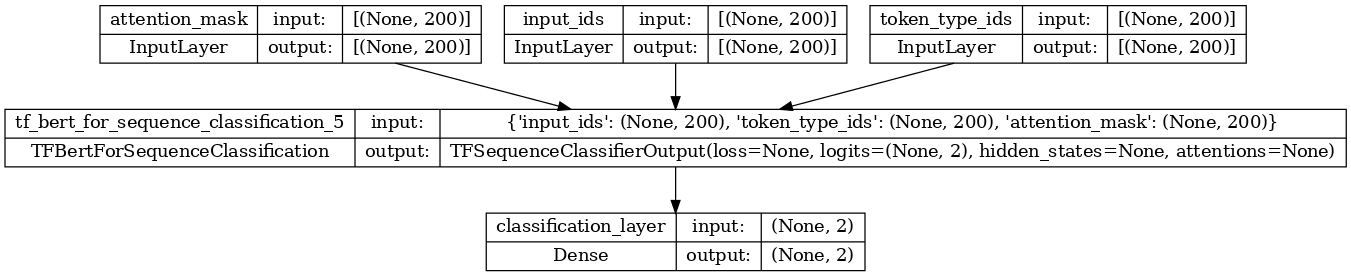

In [465]:
tf.keras.utils.plot_model(bert_classification_model, show_shapes=True, dpi=90)

In [466]:
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
print(os.getenv('TF_GPU_ALLOCATOR'))

cuda_malloc_async


In [467]:
# callbacks = keras.callbacks.ModelCheckpoint("childgrooming_NN_model_{epoch}.keras", save_best_only=True)
callbacks = tf.keras.callbacks.ModelCheckpoint(
    "pretrained_bert_weights.weights.h5",  # Filename for the saved weights
    save_best_only=True,  # Save only the best model
    save_weights_only=True,  # Save only the weights, not the full model
)

In [468]:
train_tf_dataset

<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 200), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(None, 200), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 200), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [470]:
bert_history = bert_classification_model.fit(
                        train_tf_dataset,
                        validation_data=val_tf_dataset,
                        epochs=epochs,
                        #batch_size=batch_size,
                        callbacks=[callbacks]
)
    
# model.fit(train_tf_dataset, validation_data=test_tf_dataset, epochs=epochs)

Epoch 1/40
156/156 [==============================] - 31s 199ms/step - loss: 0.7009 - accuracy: 0.5072 - val_loss: 0.6863 - val_accuracy: 0.5344
Epoch 2/40
156/156 [==============================] - 29s 187ms/step - loss: 0.6953 - accuracy: 0.5163 - val_loss: 0.6859 - val_accuracy: 0.5229
Epoch 3/40
156/156 [==============================] - 26s 168ms/step - loss: 0.6941 - accuracy: 0.5145 - val_loss: 0.6861 - val_accuracy: 0.5496
Epoch 4/40
156/156 [==============================] - 26s 168ms/step - loss: 0.6934 - accuracy: 0.5289 - val_loss: 0.6861 - val_accuracy: 0.5305
Epoch 5/40
156/156 [==============================] - 26s 168ms/step - loss: 0.6942 - accuracy: 0.5131 - val_loss: 0.6864 - val_accuracy: 0.5458
Epoch 6/40
156/156 [==============================] - 26s 168ms/step - loss: 0.6948 - accuracy: 0.5072 - val_loss: 0.6865 - val_accuracy: 0.5496
Epoch 7/40
156/156 [==============================] - 26s 168ms/step - loss: 0.6938 - accuracy: 0.5105 - val_loss: 0.6866 - val_ac

## 5.4 Run against Validation Set

In [471]:
y_pred = bert_classification_model.predict(val_tf_dataset)

9/9 [==============================] - 3s 127ms/step


In [472]:
f_max = lambda x: np.argmax(x)

In [473]:
val_y_pred = np.apply_along_axis(f_max, 1, y_pred)

In [474]:
val_y_labels = np.array(df_val_tokenized['label'])

In [475]:
# Calculate F_beta score with beta=3
f_beta3_score_test = fbeta_score(val_y_labels, val_y_pred, average='binary', beta=3, pos_label=1)
print("F1 Score (w/ Beta =3):", f_beta3_score_test)

F1 Score (w/ Beta =3): 0.35031847133757965


In [476]:
print(classification_report(val_y_labels, val_y_pred))

              precision    recall  f1-score   support

           0       0.49      0.62      0.55       133
           1       0.46      0.34      0.39       129

    accuracy                           0.48       262
   macro avg       0.48      0.48      0.47       262
weighted avg       0.48      0.48      0.47       262



## 5.5 Run against Test Set

In [477]:
y_pred_ground_truth = bert_classification_model.predict(test_tf_dataset)

4848/4848 [==============================] - 685s 141ms/step


In [478]:
test_y_pred = np.apply_along_axis(f_max, 1, y_pred_ground_truth)

In [479]:
test_y_labels = np.array(df_test_tokenized['label'])

In [480]:
# Calculate F_beta score with beta=3
f_beta3_score_test = fbeta_score(test_y_labels, test_y_pred, average='binary', beta=3, pos_label=1)
print("F1 Score (w/ Beta =3):", f_beta3_score_test)

F1 Score (w/ Beta =3): 0.12872983728208687


In [481]:
print(classification_report(test_y_labels, test_y_pred))

              precision    recall  f1-score   support

           0       0.98      0.71      0.83    152233
           1       0.02      0.31      0.04      2895

    accuracy                           0.71    155128
   macro avg       0.50      0.51      0.43    155128
weighted avg       0.96      0.71      0.81    155128



In [128]:
# import math

# def sigmoid(x):
#   return 1 / (1 + math.exp(-x))
# f_sigmoid_to_prediction = lambda x: 1 if sigmoid(x) > 0.5 else 0


In [129]:
#class_preds_truth = np.apply_along_axis(f_sigmoid_to_prediction, 1, y_pred_ground_truth["logits"])

/tmp/ipykernel_1956/536564363.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-x))


In [131]:
# counter = collections.Counter(class_preds_truth)
# counter

Counter({0: 155120})

In [ ]:
# Free up GPU memory
from numba import cuda 
device = cuda.get_current_device()
device.reset()